Dissolved Oxygen 

In [2]:
import numpy as np

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


In [4]:
grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 500),  
    np.linspace(41.3, 42.5, 500)
)


In [6]:
pip install --upgrade geopandas


     |████████████████████████████████| 1.0MB 36.0MB/s 
     |████████████████████████████████| 4.7MB 59.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7MB 39.3MB/s 
  Created wheel for pandas: filename=pandas-1.3.5-cp37-cp37m-linux_x86_64.whl size=30319322 sha256=2b399919079d9b108ebcb315b7595f9687a3df5a491238e004ce11004cd07e1e
  Stored in directory: /home/jovyan/.cache/pip/wheels/5c/f4/45/389dc711f0c5ff9adeb5245397ab18bf75182e8cff9fbfa916
Successfully built pandas
ERROR: tsfresh 0.12.0 has requirement pandas<=0.23.4,>=0.20.3, but you'll have pandas 1.3.5 which is incompatible.
ERROR: cufflinks 0.16 has requirement plotly<4.0.0a0,>=3.0.0, but you'll have plotly 4.1.0 which is incompatible.
  Found existing installation: numpy 1.17.0
    Uninstalling numpy-1.17.0:
      Successfully uninstalled numpy-1.17.0
  Found existing installation: pandas 0.23.4
    Unin

In [7]:
points_within_boundary = gpd.sjoin(grid_points, lake_erie_boundary, how='inner')


In [8]:
points_within_boundary = points_within_boundary[points_within_boundary.geometry.within(lake_erie_boundary.unary_union)]


In [9]:
import geopandas as gpd
print(gpd.__version__)

0.5.1


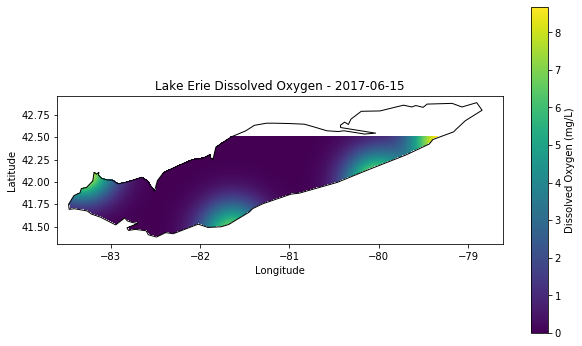

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])

lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")

gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data.longitude, data.latitude),
    crs=lake_erie_boundary.crs
)

grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 500),
    np.linspace(41.3, 42.5, 500)
)

grid_points = gpd.GeoDataFrame(
    {'geometry': gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
    crs=lake_erie_boundary.crs
)

points_within_boundary = grid_points[grid_points.geometry.within(lake_erie_boundary.unary_union)]
valid_indices = points_within_boundary.index
grid_lon_within = grid_lon.flatten()[valid_indices]
grid_lat_within = grid_lat.flatten()[valid_indices]

seasonal_months = {
    "Winter": [12, 1, 2],
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Fall": [9, 10, 11]
}

test_date = "2017-06-15"
subset = gdf[gdf.datetime == test_date]

if len(subset) > 0:
    kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(subset[['longitude', 'latitude']], subset['do_mg_L'])

    grid_values = gp.predict(np.c_[grid_lon_within, grid_lat_within])
    grid_values_full = np.full(grid_lon.size, np.nan)
    grid_values_full[valid_indices] = grid_values
    grid_values_full = grid_values_full.reshape(grid_lon.shape)

    plt.figure(figsize=(10, 6))
    plt.imshow(
        grid_values_full, origin="lower", cmap="viridis",
        extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()]
    )
    lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1)
    plt.colorbar(label="Dissolved Oxygen (mg/L)")
    plt.title(f"Lake Erie Dissolved Oxygen - {test_date}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
else:
    print(f"No data available for {test_date}.")


In [11]:
grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 800),  
    np.linspace(41.3, 42.5, 800)
)


In [12]:
from sklearn.gaussian_process.kernels import DotProduct

kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=2.0, length_scale_bounds=(1e-2, 1e3))


In [13]:
from shapely.geometry import MultiPoint

boundary_points = np.array(MultiPoint(lake_erie_boundary.geometry.iloc[0].exterior.coords).coords)
pseudo_points = pd.DataFrame({
    'longitude': boundary_points[:, 0],
    'latitude': boundary_points[:, 1],
    'do_mg_L': np.mean(subset['do_mg_L'])  # Use an average value
})
augmented_data = pd.concat([subset, pseudo_points], ignore_index=True)
gp.fit(augmented_data[['longitude', 'latitude']], augmented_data['do_mg_L'])


NotImplementedError: Multi-part geometries do not provide a coordinate sequence

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00027466, -0.00301387]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00032043, -0.00314193]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 86, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469:

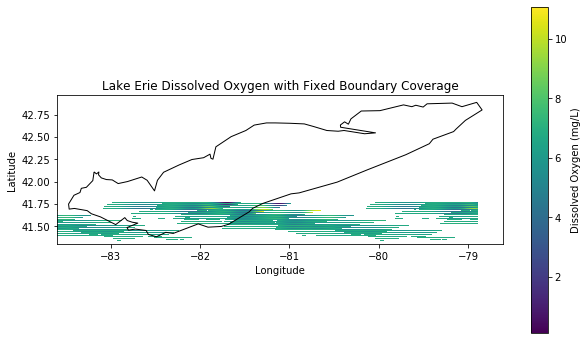

In [15]:
from shapely.geometry import MultiPolygon, Polygon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import geopandas as gpd

# Extract boundary coordinates while ensuring complete coverage
boundary_coords = []
for geom in lake_erie_boundary.geometry:
    if isinstance(geom, Polygon):
        boundary_coords.extend(np.array(geom.exterior.coords))
    elif isinstance(geom, MultiPolygon):
        for part in geom.geoms:
            boundary_coords.extend(np.array(part.exterior.coords))
boundary_points = np.array(boundary_coords)

# Generate additional pseudo points along the boundary to aid interpolation
pseudo_points = pd.DataFrame({
    'longitude': boundary_points[:, 0],
    'latitude': boundary_points[:, 1],
    'do_mg_L': np.nanmean(subset['do_mg_L'])  # Use the mean dissolved oxygen value
})

# Combine original data with pseudo points
augmented_data = pd.concat([subset, pseudo_points], ignore_index=True)

# Recreate the Gaussian Process Regression with augmented data
kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=2.0, length_scale_bounds=(1e-2, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(augmented_data[['longitude', 'latitude']], augmented_data['do_mg_L'])

# Predict over the lake grid
grid_values = gp.predict(np.c_[grid_lon_within, grid_lat_within])
grid_values_full = np.full(grid_lon.size, np.nan)
grid_values_full[valid_indices] = grid_values
grid_values_full = grid_values_full.reshape(grid_lon.shape)

# Plot the updated map
plt.figure(figsize=(10, 6))
plt.imshow(
    grid_values_full, origin="lower", cmap="viridis",
    extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()]
)
lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1)
plt.colorbar(label="Dissolved Oxygen (mg/L)")
plt.title(f"Lake Erie Dissolved Oxygen with Fixed Boundary Coverage")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


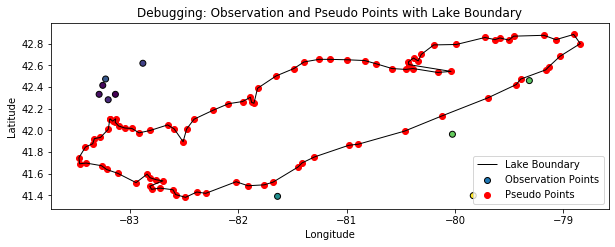

In [16]:
# Plot the lake boundary and pseudo-points for debugging
plt.figure(figsize=(10, 6))
lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1, label="Lake Boundary")

# Plot original dissolved oxygen points
plt.scatter(subset["longitude"], subset["latitude"], c=subset["do_mg_L"], cmap="viridis", edgecolor="k", label="Observation Points")

# Add pseudo-points to verify their placement
plt.scatter(pseudo_points["longitude"], pseudo_points["latitude"], c="red", label="Pseudo Points")

plt.title("Debugging: Observation and Pseudo Points with Lake Boundary")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


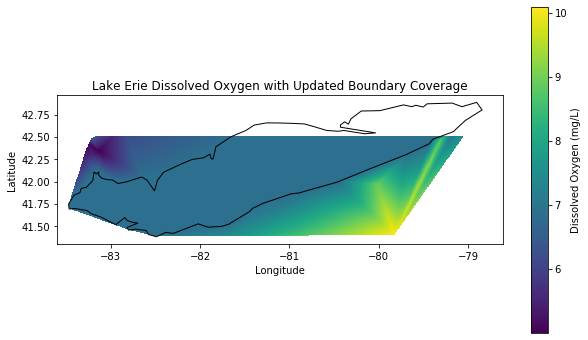

In [18]:
# Merge pseudo-points with observation points
pseudo_points["do_mg_L"] = subset["do_mg_L"].mean()  # Assign average DO value to pseudo-points
combined_data = pd.concat([subset, pseudo_points])

# Interpolate with combined data
from scipy.interpolate import griddata

combined_points = combined_data[["longitude", "latitude"]].values
combined_values = combined_data["do_mg_L"].values

grid_values = griddata(combined_points, combined_values, (grid_lon, grid_lat), method="linear")

# Plot the updated interpolation
plt.figure(figsize=(10, 6))
plt.imshow(
    grid_values, origin="lower", cmap="viridis",
    extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()]
)
lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1)
plt.colorbar(label="Dissolved Oxygen (mg/L)")
plt.title("Lake Erie Dissolved Oxygen with Updated Boundary Coverage")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


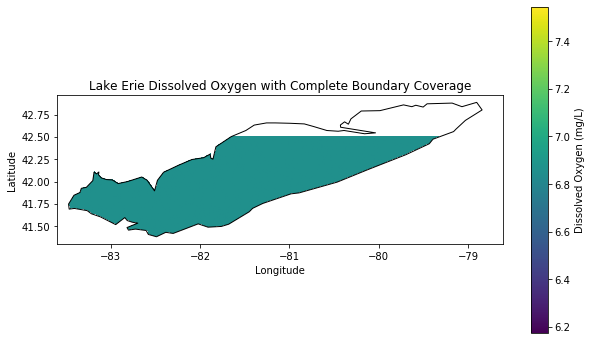

In [19]:
from shapely.geometry import MultiPoint, Polygon
from scipy.spatial import Delaunay
from scipy.interpolate import griddata

# Generate more pseudo-points along the lake boundary
boundary_coords = np.array(lake_erie_boundary.geometry.iloc[0].exterior.coords)
additional_pseudo_points = pd.DataFrame({
    'longitude': boundary_coords[:, 0],
    'latitude': boundary_coords[:, 1],
    'do_mg_L': subset["do_mg_L"].mean()  # Assign average dissolved oxygen to boundary points
})

# Merge original data with pseudo-points
combined_data = pd.concat([subset, pseudo_points, additional_pseudo_points], ignore_index=True)

# Interpolate data over a finer grid
grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 600),  # Finer resolution
    np.linspace(41.3, 42.5, 600)
)
combined_points = combined_data[["longitude", "latitude"]].values
combined_values = combined_data["do_mg_L"].values
grid_values = griddata(combined_points, combined_values, (grid_lon, grid_lat), method="linear")

# Mask the grid to Lake Erie boundary
grid_points = gpd.GeoDataFrame({
    'geometry': gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())
}, crs=lake_erie_boundary.crs)
grid_within_boundary = grid_points[grid_points.geometry.within(lake_erie_boundary.geometry.iloc[0])]
valid_indices = grid_within_boundary.index
grid_values_masked = np.full(grid_lon.size, np.nan)
grid_values_masked[valid_indices] = grid_values.flatten()[valid_indices]
grid_values_masked = grid_values_masked.reshape(grid_lon.shape)

# Plot updated map
plt.figure(figsize=(10, 6))
plt.imshow(
    grid_values_masked, origin="lower", cmap="viridis",
    extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()]
)
lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1)
plt.colorbar(label="Dissolved Oxygen (mg/L)")
plt.title("Lake Erie Dissolved Oxygen with Complete Boundary Coverage")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


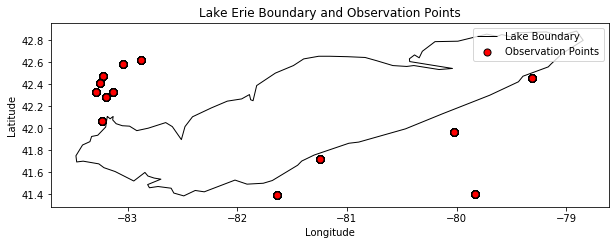

In [20]:
import matplotlib.pyplot as plt

# Plot the Lake Erie boundary
plt.figure(figsize=(10, 6))
lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1, label="Lake Boundary")

# Plot original observation points
plt.scatter(
    gdf["longitude"], gdf["latitude"], c="red", edgecolor="black", s=50, label="Observation Points"
)

plt.title("Lake Erie Boundary and Observation Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


In [21]:
print("GeoJSON CRS:", lake_erie_boundary.crs)
print("Observation Data CRS:", gdf.crs)


GeoJSON CRS: {'init': 'epsg:4326'}
Observation Data CRS: {'init': 'epsg:4326'}


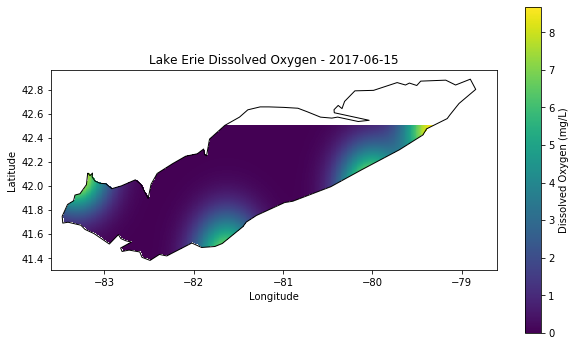

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Load observation data and lake boundary
data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")

# Ensure CRS alignment
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude), crs=lake_erie_boundary.crs)

# Create a grid for interpolation
grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 500),
    np.linspace(41.3, 42.5, 500)
)

grid_points = gpd.GeoDataFrame(
    {'geometry': gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
    crs=lake_erie_boundary.crs
)

points_within_boundary = gpd.sjoin(grid_points, lake_erie_boundary, how='inner')
valid_indices = points_within_boundary.index
grid_lon_within = grid_lon.flatten()[valid_indices]
grid_lat_within = grid_lat.flatten()[valid_indices]

# Add pseudo-points along the boundary
boundary_points = np.array(lake_erie_boundary.geometry.iloc[0].exterior.coords)
pseudo_points = pd.DataFrame({
    'longitude': boundary_points[:, 0],
    'latitude': boundary_points[:, 1],
    'do_mg_L': np.nan
})

# Specify test date
test_date = "2017-06-15"
subset = gdf[gdf['datetime'] == test_date]

if len(subset) > 0:
    combined_data = pd.concat([subset[['longitude', 'latitude', 'do_mg_L']], pseudo_points], ignore_index=True)
    combined_gdf = gpd.GeoDataFrame(
        combined_data,
        geometry=gpd.points_from_xy(combined_data['longitude'], combined_data['latitude']),
        crs=lake_erie_boundary.crs
    )

    # Gaussian Process Regression
    real_data = combined_data.dropna(subset=['do_mg_L'])
    kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(real_data[['longitude', 'latitude']], real_data['do_mg_L'])

    grid_values = gp.predict(np.c_[grid_lon_within, grid_lat_within])
    grid_values_full = np.full(grid_lon.size, np.nan)
    grid_values_full[valid_indices] = grid_values
    grid_values_full = grid_values_full.reshape(grid_lon.shape)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(
        grid_values_full, origin='lower', cmap='viridis',
        extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()]
    )
    lake_erie_boundary.boundary.plot(ax=plt.gca(), color='black', linewidth=1)
    plt.colorbar(label="Dissolved Oxygen (mg/L)")
    plt.title(f"Lake Erie Dissolved Oxygen - {test_date}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
else:
    print(f"No data available for {test_date}.")



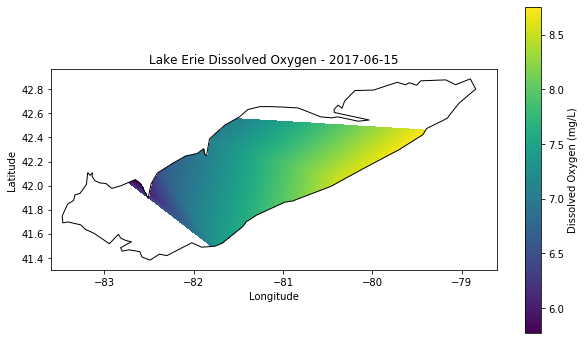

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.interpolate import griddata

# Load data
data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude), crs=lake_erie_boundary.crs)

# Generate a finer grid
grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 1000),  # Higher resolution
    np.linspace(41.3, 42.8, 1000)
)

grid_points = gpd.GeoDataFrame(
    {'geometry': gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
    crs=lake_erie_boundary.crs
)

# Filter points within the boundary
points_within_boundary = gpd.sjoin(grid_points, lake_erie_boundary, how='inner')
valid_indices = points_within_boundary.index
grid_lon_within = grid_lon.flatten()[valid_indices]
grid_lat_within = grid_lat.flatten()[valid_indices]

# Test on a single date
test_date = "2017-06-15"
subset = gdf[gdf["datetime"] == test_date]

if not subset.empty:
    # Interpolate using griddata
    grid_values = griddata(
        subset[["longitude", "latitude"]], subset["do_mg_L"],
        (grid_lon_within, grid_lat_within), method="linear"
    )
    
    # Create a full grid for visualization
    full_grid_values = np.full(grid_lon.size, np.nan)
    full_grid_values[valid_indices] = grid_values
    full_grid_values = full_grid_values.reshape(grid_lon.shape)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(
        full_grid_values, origin="lower", cmap="viridis",
        extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()]
    )
    lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1)
    plt.colorbar(label="Dissolved Oxygen (mg/L)")
    plt.title(f"Lake Erie Dissolved Oxygen - {test_date}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
else:
    print(f"No data available for {test_date}.")


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.interpolate import griddata, NearestNDInterpolator

data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude), crs=lake_erie_boundary.crs)

# Generate a finer grid
grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 1000),
    np.linspace(41.3, 42.8, 1000)
)

# Add pseudo points along the boundary
boundary_coords = np.array(lake_erie_boundary.geometry.iloc[0].exterior.coords)
pseudo_points = pd.DataFrame({
    'longitude': boundary_coords[:, 0],
    'latitude': boundary_coords[:, 1],
    'do_mg_L': np.nanmean(data['do_mg_L'])  # Assign an average value or a constant
})

# Combine original data with pseudo points
combined_data = pd.concat([data, pseudo_points], ignore_index=True)

# Test on a single date
test_date = "2017-06-15"
subset = gdf[gdf["datetime"] == test_date]

if not subset.empty:
    # Combine subset with pseudo points
    subset_with_pseudo = pd.concat([subset, pseudo_points], ignore_index=True)

    # Interpolate using Nearest Neighbor for extrapolation
    interpolator = NearestNDInterpolator(
        subset_with_pseudo[["longitude", "latitude"]],
        subset_with_pseudo["do_mg_L"]
    )
    grid_values = interpolator(grid_lon.flatten(), grid_lat.flatten())

    # Reshape to grid
    full_grid_values = grid_values.reshape(grid_lon.shape)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(
        full_grid_values, origin="lower", cmap="viridis",
        extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()]
    )
    lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1)
    plt.colorbar(label="Dissolved Oxygen (mg/L)")
    plt.title(f"Lake Erie Dissolved Oxygen - {test_date}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
else:
    print(f"No data available for {test_date}.")


AttributeError: 'Series' object has no attribute 'reshape'

In [4]:
import numpy as np

grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 200),
    np.linspace(41.3, 42.5, 200)
)


In [7]:
import pandas as pd



/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [8]:
# Combine actual data with pseudo-points
subset_with_pseudo = pd.concat([subset, pseudo_points], ignore_index=True)


NameError: name 'subset' is not defined

In [9]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPoint
from scipy.interpolate import griddata

# Load data
data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")

# Create GeoDataFrame for observation data
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["longitude"], data["latitude"]),
    crs=lake_erie_boundary.crs
)

# Generate pseudo-points along the boundary
boundary_points = np.array(
    MultiPoint(np.concatenate([geom.exterior.coords for geom in lake_erie_boundary.geometry if geom.exterior is not None])).coords
)
pseudo_points = pd.DataFrame({
    'longitude': boundary_points[:, 0],
    'latitude': boundary_points[:, 1],
    'do_mg_L': np.full(boundary_points.shape[0], np.nan)  # No data for pseudo-points
})

# Define grid for interpolation
grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 300),  # Adjust grid resolution as needed
    np.linspace(41.3, 42.5, 300)
)

# Test on one date for visualization
test_date = "2017-06-15"
subset = gdf[gdf["datetime"] == test_date]

if not subset.empty:
    # Combine actual data with pseudo-points
    subset_with_pseudo = pd.concat([subset, pseudo_points], ignore_index=True)
    
    # Interpolation using griddata
    grid_values = griddata(
        points=subset_with_pseudo[["longitude", "latitude"]],
        values=subset_with_pseudo["do_mg_L"],
        xi=(grid_lon, grid_lat),
        method="linear"
    )
    
    # Mask values outside the boundary
    lake_mask = gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten()).within(lake_erie_boundary.unary_union)
    grid_values = np.where(lake_mask.reshape(grid_lon.shape), grid_values, np.nan)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.imshow(
        grid_values, origin="lower", cmap="viridis",
        extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()]
    )
    lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1, label="Lake Boundary")
    plt.colorbar(label="Dissolved Oxygen (mg/L)")
    plt.title(f"Lake Erie Dissolved Oxygen - {test_date}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.show()
else:
    print(f"No data available for {test_date}.")


NotImplementedError: Multi-part geometries do not provide a coordinate sequence

/opt/conda/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/opt/conda/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/opt/conda/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/opt/conda/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/opt/conda/lib/python3.7/site-packages/numpy/ma/core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


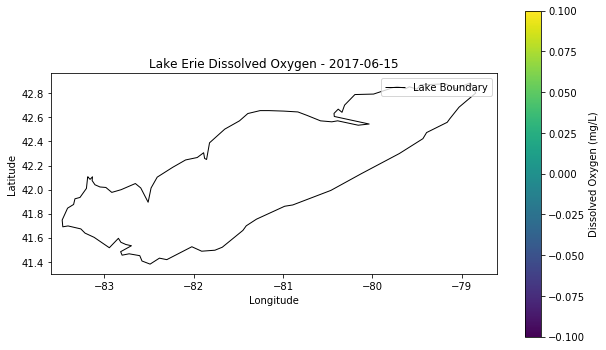

In [10]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPoint, Point
from scipy.interpolate import griddata

# Load data
data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")

# Create GeoDataFrame for observation data
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["longitude"], data["latitude"]),
    crs=lake_erie_boundary.crs
)

# Generate pseudo-points along the boundary
boundary_coords = []
for geom in lake_erie_boundary.geometry:
    if geom.geom_type == "Polygon":
        boundary_coords.extend(geom.exterior.coords)
    elif geom.geom_type == "MultiPolygon":
        for poly in geom:
            boundary_coords.extend(poly.exterior.coords)

boundary_points = np.array(boundary_coords)
pseudo_points = pd.DataFrame({
    'longitude': boundary_points[:, 0],
    'latitude': boundary_points[:, 1],
    'do_mg_L': np.full(boundary_points.shape[0], np.nan)  # No data for pseudo-points
})

# Define grid for interpolation
grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 300),  # Adjust grid resolution as needed
    np.linspace(41.3, 42.5, 300)
)

# Test on one date for visualization
test_date = "2017-06-15"
subset = gdf[gdf["datetime"] == test_date]

if not subset.empty:
    # Combine actual data with pseudo-points
    subset_with_pseudo = pd.concat([subset, pseudo_points], ignore_index=True)
    
    # Interpolation using griddata
    grid_values = griddata(
        points=subset_with_pseudo[["longitude", "latitude"]],
        values=subset_with_pseudo["do_mg_L"],
        xi=(grid_lon, grid_lat),
        method="linear"
    )
    
    # Mask values outside the boundary
    mask_points = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten()), crs=lake_erie_boundary.crs
    )
    lake_mask = mask_points.within(lake_erie_boundary.unary_union).values.reshape(grid_lon.shape)
    grid_values = np.where(lake_mask, grid_values, np.nan)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.imshow(
        grid_values, origin="lower", cmap="viridis",
        extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()]
    )
    lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1, label="Lake Boundary")
    plt.colorbar(label="Dissolved Oxygen (mg/L)")
    plt.title(f"Lake Erie Dissolved Oxygen - {test_date}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.show()
else:
    print(f"No data available for {test_date}.")


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging

# Load observation data
data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude), crs=lake_erie_boundary.crs)

# Define a test date for kriging
test_date = "2017-06-15"
subset = gdf[gdf["datetime"] == test_date]

# Define grid for interpolation
grid_lon = np.linspace(-83.6, -78.9, 200)
grid_lat = np.linspace(41.3, 42.5, 200)
grid_x, grid_y = np.meshgrid(grid_lon, grid_lat)

# Extract coordinates and values for kriging
coords = subset[["longitude", "latitude"]].values
values = subset["do_mg_L"].values

# Perform ordinary kriging
kriging_model = OrdinaryKriging(
    coords[:, 0], coords[:, 1], values,
    variogram_model="spherical",
    verbose=False,
    enable_plotting=False
)
z, ss = kriging_model.execute("grid", grid_lon, grid_lat)

# Mask kriging results to the lake boundary
grid_points = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(grid_x.flatten(), grid_y.flatten()), crs=gdf.crs
)
points_within_boundary = gpd.sjoin(grid_points, lake_erie_boundary, how="inner")
valid_indices = points_within_boundary.index
z_within_boundary = np.full(grid_x.size, np.nan)
z_within_boundary[valid_indices] = z.flatten()[valid_indices]
z_within_boundary = z_within_boundary.reshape(grid_x.shape)

# Plot kriging results
plt.figure(figsize=(10, 6))
plt.imshow(
    z_within_boundary, origin="lower", cmap="viridis",
    extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()]
)
lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1)
plt.colorbar(label="Dissolved Oxygen (mg/L)")
plt.title(f"Lake Erie Dissolved Oxygen - {test_date} (Kriging)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


ModuleNotFoundError: No module named 'pykrige'

In [2]:
!pip install pykrige


     |████████████████████████████████| 624kB 25.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pykrige: filename=PyKrige-1.7.0-cp37-cp37m-linux_x86_64.whl size=620041 sha256=93dc7f41eb729a241e5bb6ae76a169e1c267e79c9ab0f5a4a0d0e3acd9dc9eae
  Stored in directory: /home/jovyan/.cache/pip/wheels/a5/cc/7f/0af9c0eead922c4b95f38bc845a5326da94ec02c7e1c1ba205
Successfully built pykrige


In [3]:
!pip install --upgrade numexpr


     |████████████████████████████████| 102kB 21.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for numexpr: filename=numexpr-2.8.6-cp37-cp37m-linux_x86_64.whl size=352671 sha256=04e59930d201cf6daa70f078b0d73dfc6c485f7b12cb6c701917a3c7b9a055d3
  Stored in directory: /home/jovyan/.cache/pip/wheels/50/c1/6e/460a4e5131d205bce3d1a4fb54a2268fd20cda32a568418ba6
Successfully built numexpr
  Found existing installation: numexpr 2.6.9
    Uninstalling numexpr-2.6.9:
      Successfully uninstalled numexpr-2.6.9


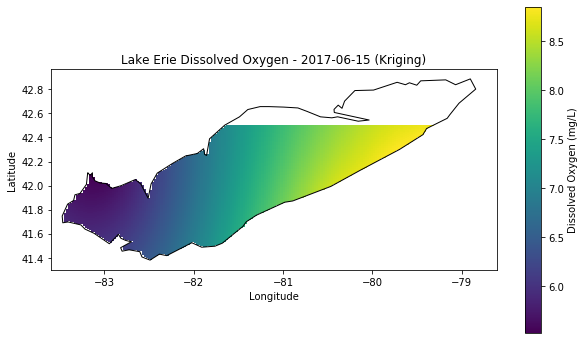

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging

# Load observation data
data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude), crs=lake_erie_boundary.crs)

# Define a test date for kriging
test_date = "2017-06-15"
subset = gdf[gdf["datetime"] == test_date]

# Define grid for interpolation
grid_lon = np.linspace(-83.6, -78.9, 200)
grid_lat = np.linspace(41.3, 42.5, 200)
grid_x, grid_y = np.meshgrid(grid_lon, grid_lat)

# Extract coordinates and values for kriging
coords = subset[["longitude", "latitude"]].values
values = subset["do_mg_L"].values

# Perform ordinary kriging
kriging_model = OrdinaryKriging(
    coords[:, 0], coords[:, 1], values,
    variogram_model="spherical",
    verbose=False,
    enable_plotting=False
)
z, ss = kriging_model.execute("grid", grid_lon, grid_lat)

# Mask kriging results to the lake boundary
grid_points = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(grid_x.flatten(), grid_y.flatten()), crs=gdf.crs
)
points_within_boundary = gpd.sjoin(grid_points, lake_erie_boundary, how="inner")
valid_indices = points_within_boundary.index
z_within_boundary = np.full(grid_x.size, np.nan)
z_within_boundary[valid_indices] = z.flatten()[valid_indices]
z_within_boundary = z_within_boundary.reshape(grid_x.shape)

# Plot kriging results
plt.figure(figsize=(10, 6))
plt.imshow(
    z_within_boundary, origin="lower", cmap="viridis",
    extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()]
)
lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1)
plt.colorbar(label="Dissolved Oxygen (mg/L)")
plt.title(f"Lake Erie Dissolved Oxygen - {test_date} (Kriging)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import MultiPoint

# Load data
lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")
data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data["longitude"], data["latitude"]), crs=lake_erie_boundary.crs
)

# Set up grid
grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 200),  # Adjust resolution if needed
    np.linspace(41.3, 42.8, 200)
)
grid_points = gpd.GeoDataFrame(
    {"geometry": gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
    crs=lake_erie_boundary.crs,
)

# Add pseudo-points along the boundary
boundary_points = np.array(
    MultiPoint(np.concatenate([geom.exterior.coords for geom in lake_erie_boundary.geometry if geom.exterior is not None])).coords
)
pseudo_points = pd.DataFrame({
    "longitude": boundary_points[:, 0],
    "latitude": boundary_points[:, 1],
    "do_mg_L": np.mean(data["do_mg_L"]),  # Assign an average dissolved oxygen value
})
pseudo_gdf = gpd.GeoDataFrame(
    pseudo_points, geometry=gpd.points_from_xy(pseudo_points["longitude"], pseudo_points["latitude"]), crs=gdf.crs
)

# Combine observation data with pseudo-points
subset = gdf[gdf["datetime"] == "2017-06-15"]  # Example date
if not subset.empty:
    combined_gdf = pd.concat([subset, pseudo_gdf], ignore_index=True)

    # Kriging
    kriging = OrdinaryKriging(
        combined_gdf["longitude"], combined_gdf["latitude"], combined_gdf["do_mg_L"],
        variogram_model="linear",
    )
    z, ss = kriging.execute("grid", grid_lon[0], grid_lat[:, 0])

    # Mask outside the boundary
    grid_gdf = gpd.GeoDataFrame(
        {"geometry": gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
        crs=lake_erie_boundary.crs,
    )
    grid_gdf["value"] = z.flatten()
    grid_within = gpd.sjoin(grid_gdf, lake_erie_boundary, how="inner", predicate="within")
    z_masked = np.full_like(z, np.nan)
    z_masked[grid_within.index] = grid_within["value"]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(
        z_masked, origin="lower", cmap="viridis",
        extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()],
    )
    lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1, label="Lake Boundary")
    plt.colorbar(label="Dissolved Oxygen (mg/L)")
    plt.title("Lake Erie Dissolved Oxygen - 2017-06-15 (Kriging with Boundary Pseudo-Points)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.show()
else:
    print("No data available for the given date.")


NotImplementedError: Multi-part geometries do not provide a coordinate sequence

In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import MultiLineString, Polygon

# Load data
lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")
data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data["longitude"], data["latitude"]), crs=lake_erie_boundary.crs
)

# Set up grid
grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 200),
    np.linspace(41.3, 42.8, 200)
)
grid_points = gpd.GeoDataFrame(
    {"geometry": gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
    crs=lake_erie_boundary.crs,
)

# Extract boundary points (handle multi-part geometries)
boundary_points = []
for geom in lake_erie_boundary.geometry:
    if isinstance(geom, Polygon):
        boundary_points.extend(np.array(geom.exterior.coords))
    elif isinstance(geom, MultiLineString) or isinstance(geom, MultiPolygon):
        for part in geom.geoms:
            if part.exterior:
                boundary_points.extend(np.array(part.exterior.coords))
boundary_points = np.array(boundary_points)

# Create pseudo-points
pseudo_points = pd.DataFrame({
    "longitude": boundary_points[:, 0],
    "latitude": boundary_points[:, 1],
    "do_mg_L": np.mean(data["do_mg_L"]),
})
pseudo_gdf = gpd.GeoDataFrame(
    pseudo_points, geometry=gpd.points_from_xy(pseudo_points["longitude"], pseudo_points["latitude"]), crs=gdf.crs
)

# Combine observation data with pseudo-points
subset = gdf[gdf["datetime"] == "2017-06-15"]  # Example date
if not subset.empty:
    combined_gdf = pd.concat([subset, pseudo_gdf], ignore_index=True)

    # Kriging
    kriging = OrdinaryKriging(
        combined_gdf["longitude"], combined_gdf["latitude"], combined_gdf["do_mg_L"],
        variogram_model="linear",
    )
    z, ss = kriging.execute("grid", grid_lon[0], grid_lat[:, 0])

    # Mask outside the boundary
    grid_gdf = gpd.GeoDataFrame(
        {"geometry": gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
        crs=lake_erie_boundary.crs,
    )
    grid_gdf["value"] = z.flatten()
    grid_within = gpd.sjoin(grid_gdf, lake_erie_boundary, how="inner", predicate="within")
    z_masked = np.full_like(z, np.nan)
    z_masked[grid_within.index] = grid_within["value"]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(
        z_masked, origin="lower", cmap="viridis",
        extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()],
    )
    lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1, label="Lake Boundary")
    plt.colorbar(label="Dissolved Oxygen (mg/L)")
    plt.title("Lake Erie Dissolved Oxygen - 2017-06-15 (Kriging with Boundary Pseudo-Points)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.show()
else:
    print("No data available for the given date.")


TypeError: float() argument must be a string or a number, not 'SingleBlockManager'

In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import MultiLineString, Polygon, MultiPolygon

lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")
data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data["longitude"], data["latitude"]), crs=lake_erie_boundary.crs
)

grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 200),
    np.linspace(41.3, 42.8, 200)
)
grid_points = gpd.GeoDataFrame(
    {"geometry": gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
    crs=lake_erie_boundary.crs,
)

boundary_points = []
for geom in lake_erie_boundary.geometry:
    if isinstance(geom, Polygon):
        boundary_points.extend(np.array(geom.exterior.coords))
    elif isinstance(geom, MultiPolygon):
        for part in geom.geoms:
            boundary_points.extend(np.array(part.exterior.coords))
boundary_points = np.array(boundary_points)

pseudo_points = pd.DataFrame({
    "longitude": boundary_points[:, 0],
    "latitude": boundary_points[:, 1],
    "do_mg_L": np.mean(data["do_mg_L"]),
})
pseudo_gdf = gpd.GeoDataFrame(
    pseudo_points, geometry=gpd.points_from_xy(pseudo_points["longitude"], pseudo_points["latitude"]), crs=gdf.crs
)

subset = gdf[gdf["datetime"] == "2017-06-15"]
if not subset.empty:
    combined_gdf = pd.concat([subset, pseudo_gdf], ignore_index=True)

    kriging = OrdinaryKriging(
        combined_gdf["longitude"], combined_gdf["latitude"], combined_gdf["do_mg_L"],
        variogram_model="linear",
    )
    z, ss = kriging.execute("grid", grid_lon[0], grid_lat[:, 0])

    grid_gdf = gpd.GeoDataFrame(
        {"geometry": gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
        crs=lake_erie_boundary.crs,
    )
    grid_gdf["value"] = z.flatten()
    grid_within = gpd.sjoin(grid_gdf, lake_erie_boundary, how="inner", predicate="within")

    z_masked = np.full(z.shape, np.nan)
    grid_within_values = grid_within["value"].to_numpy()  # Ensure values are in NumPy array format
    z_masked[grid_within.index] = grid_within_values

    plt.figure(figsize=(10, 6))
    plt.imshow(
        z_masked, origin="lower", cmap="viridis",
        extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()],
    )
    lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1, label="Lake Boundary")
    plt.colorbar(label="Dissolved Oxygen (mg/L)")
    plt.title("Lake Erie Dissolved Oxygen - 2017-06-15 (Kriging with Boundary Pseudo-Points)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.show()
else:
    print("No data available for the given date.")


ValueError: shape mismatch: value array of shape (15152,) could not be broadcast to indexing result of shape (15152,200)

In [8]:
# Create an empty masked array to hold values within the lake boundary
z_masked = np.full_like(z, np.nan)

# Create a lookup index for valid grid cells within the boundary
valid_mask = ~np.isnan(z.flatten())  # Check which values are valid
z_masked_flat = z.flatten()  # Flatten the grid for assignment

# Assign the kriging results to the flattened masked grid
z_masked_flat[valid_mask] = z.flatten()[valid_mask]

# Reshape back to the original grid shape
z_masked = z_masked_flat.reshape(z.shape)

# Ensure grid_within only includes points matching the grid
valid_indices = grid_within.index
z_masked.flat[valid_indices] = grid_within_values  # Use flat indexing for assignment


IndexError: unsupported iterator index

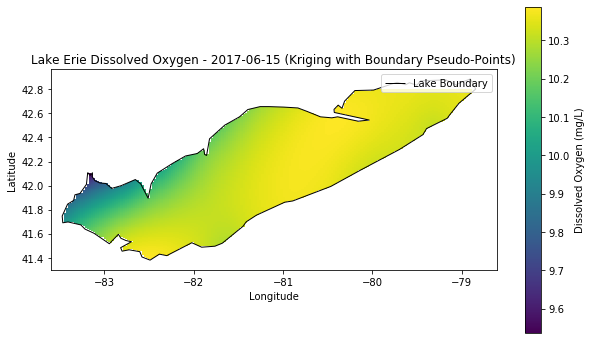

In [9]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Polygon, MultiPolygon

lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")
data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data["longitude"], data["latitude"]), crs=lake_erie_boundary.crs
)

grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 200),
    np.linspace(41.3, 42.8, 200)
)

boundary_points = []
for geom in lake_erie_boundary.geometry:
    if isinstance(geom, Polygon):
        boundary_points.extend(np.array(geom.exterior.coords))
    elif isinstance(geom, MultiPolygon):
        for part in geom.geoms:
            boundary_points.extend(np.array(part.exterior.coords))
boundary_points = np.array(boundary_points)

pseudo_points = pd.DataFrame({
    "longitude": boundary_points[:, 0],
    "latitude": boundary_points[:, 1],
    "do_mg_L": np.mean(data["do_mg_L"]),
})
pseudo_gdf = gpd.GeoDataFrame(
    pseudo_points, geometry=gpd.points_from_xy(pseudo_points["longitude"], pseudo_points["latitude"]), crs=gdf.crs
)

subset = gdf[gdf["datetime"] == "2017-06-15"]
if not subset.empty:
    combined_gdf = pd.concat([subset, pseudo_gdf], ignore_index=True)

    kriging = OrdinaryKriging(
        combined_gdf["longitude"], combined_gdf["latitude"], combined_gdf["do_mg_L"],
        variogram_model="linear",
    )
    z, ss = kriging.execute("grid", grid_lon[0], grid_lat[:, 0])

    grid_gdf = gpd.GeoDataFrame(
        {"geometry": gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
        crs=lake_erie_boundary.crs,
    )
    grid_gdf["value"] = z.flatten()
    grid_within = gpd.sjoin(grid_gdf, lake_erie_boundary, how="inner", predicate="within")

    z_masked = np.full(z.shape, np.nan)
    for idx, row in grid_within.iterrows():
        lon_idx = np.argmin(np.abs(grid_lon[0] - row.geometry.x))
        lat_idx = np.argmin(np.abs(grid_lat[:, 0] - row.geometry.y))
        z_masked[lat_idx, lon_idx] = row["value"]

    plt.figure(figsize=(10, 6))
    plt.imshow(
        z_masked, origin="lower", cmap="viridis",
        extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()],
    )
    lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1, label="Lake Boundary")
    plt.colorbar(label="Dissolved Oxygen (mg/L)")
    plt.title("Lake Erie Dissolved Oxygen - 2017-06-15 (Kriging with Boundary Pseudo-Points)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.show()
else:
    print("No data available for the given date.")


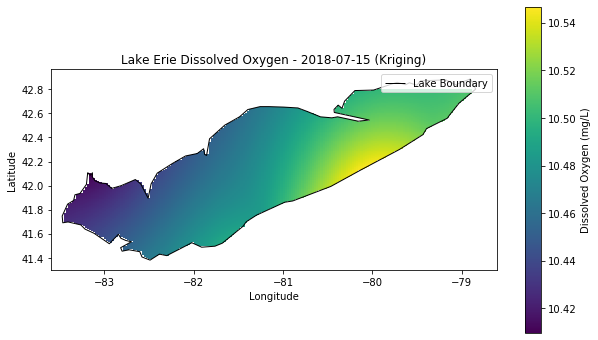

In [10]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Polygon, MultiPolygon

lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")
data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data["longitude"], data["latitude"]), crs=lake_erie_boundary.crs
)

grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 200),
    np.linspace(41.3, 42.8, 200)
)

boundary_points = []
for geom in lake_erie_boundary.geometry:
    if isinstance(geom, Polygon):
        boundary_points.extend(np.array(geom.exterior.coords))
    elif isinstance(geom, MultiPolygon):
        for part in geom.geoms:
            boundary_points.extend(np.array(part.exterior.coords))
boundary_points = np.array(boundary_points)

pseudo_points = pd.DataFrame({
    "longitude": boundary_points[:, 0],
    "latitude": boundary_points[:, 1],
    "do_mg_L": np.mean(data["do_mg_L"]),
})
pseudo_gdf = gpd.GeoDataFrame(
    pseudo_points, geometry=gpd.points_from_xy(pseudo_points["longitude"], pseudo_points["latitude"]), crs=gdf.crs
)

subset = gdf[gdf["datetime"] == "2018-07-15"]
if not subset.empty:
    combined_gdf = pd.concat([subset, pseudo_gdf], ignore_index=True)

    kriging = OrdinaryKriging(
        combined_gdf["longitude"], combined_gdf["latitude"], combined_gdf["do_mg_L"],
        variogram_model="linear",
    )
    z, ss = kriging.execute("grid", grid_lon[0], grid_lat[:, 0])

    grid_gdf = gpd.GeoDataFrame(
        {"geometry": gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
        crs=lake_erie_boundary.crs,
    )
    grid_gdf["value"] = z.flatten()
    grid_within = gpd.sjoin(grid_gdf, lake_erie_boundary, how="inner", predicate="within")

    z_masked = np.full(z.shape, np.nan)
    for idx, row in grid_within.iterrows():
        lon_idx = np.argmin(np.abs(grid_lon[0] - row.geometry.x))
        lat_idx = np.argmin(np.abs(grid_lat[:, 0] - row.geometry.y))
        z_masked[lat_idx, lon_idx] = row["value"]

    plt.figure(figsize=(10, 6))
    plt.imshow(
        z_masked, origin="lower", cmap="viridis",
        extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()],
    )
    lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1, label="Lake Boundary")
    plt.colorbar(label="Dissolved Oxygen (mg/L)")
    plt.title("Lake Erie Dissolved Oxygen - 2018-07-15 (Kriging)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.show()
else:
    print("No data available for the given date.")


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Polygon, MultiPolygon

lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")
data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data["longitude"], data["latitude"]), crs=lake_erie_boundary.crs
)

grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 200),
    np.linspace(41.3, 42.8, 200)
)

boundary_points = []
for geom in lake_erie_boundary.geometry:
    if isinstance(geom, Polygon):
        boundary_points.extend(np.array(geom.exterior.coords))
    elif isinstance(geom, MultiPolygon):
        for part in geom.geoms:
            boundary_points.extend(np.array(part.exterior.coords))
boundary_points = np.array(boundary_points)

pseudo_points = pd.DataFrame({
    "longitude": boundary_points[:, 0],
    "latitude": boundary_points[:, 1],
    "do_mg_L": np.mean(data["do_mg_L"]),
})
pseudo_gdf = gpd.GeoDataFrame(
    pseudo_points, geometry=gpd.points_from_xy(pseudo_points["longitude"], pseudo_points["latitude"]), crs=gdf.crs
)

seasonal_months = {
    "Winter": [12, 1, 2],
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Fall": [9, 10, 11],
}

def process_season(year, season, months):
    subset = gdf[(gdf["datetime"].dt.year == year) & (gdf["datetime"].dt.month.isin(months))]
    if not subset.empty:
        combined_gdf = pd.concat([subset, pseudo_gdf], ignore_index=True)
        kriging = OrdinaryKriging(
            combined_gdf["longitude"], combined_gdf["latitude"], combined_gdf["do_mg_L"],
            variogram_model="linear",
        )
        z, ss = kriging.execute("grid", grid_lon[0], grid_lat[:, 0])

        grid_gdf = gpd.GeoDataFrame(
            {"geometry": gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
            crs=lake_erie_boundary.crs,
        )
        grid_gdf["value"] = z.flatten()
        grid_within = gpd.sjoin(grid_gdf, lake_erie_boundary, how="inner", predicate="within")

        z_masked = np.full(z.shape, np.nan)
        for idx, row in grid_within.iterrows():
            lon_idx = np.argmin(np.abs(grid_lon[0] - row.geometry.x))
            lat_idx = np.argmin(np.abs(grid_lat[:, 0] - row.geometry.y))
            z_masked[lat_idx, lon_idx] = row["value"]

        plt.figure(figsize=(10, 6))
        plt.imshow(
            z_masked, origin="lower", cmap="viridis",
            extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()],
        )
        lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1, label="Lake Boundary")
        plt.colorbar(label="Dissolved Oxygen (mg/L)")
        plt.title(f"Lake Erie {season} Dissolved Oxygen - {year} (Kriging)")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.savefig(f"lake_erie_{year}_{season}.png")
        plt.close()
    else:
        print(f"No data available for {year} {season}.")

def process_year(year):
    for season, months in seasonal_months.items():
        process_season(year, season, months)
    print(f"Finished processing {year}.")

for year in range(2009, 2024):
    process_year(year)


No data available for 2009 Winter.
No data available for 2009 Spring.
No data available for 2009 Summer.
No data available for 2009 Fall.
Finished processing 2009.
No data available for 2010 Winter.
Finished processing 2010.
Finished processing 2011.


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Polygon, MultiPolygon

lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")
data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data["longitude"], data["latitude"]), crs=lake_erie_boundary.crs
)

grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 200),
    np.linspace(41.3, 42.8, 200)
)

boundary_points = []
for geom in lake_erie_boundary.geometry:
    if isinstance(geom, Polygon):
        boundary_points.extend(np.array(geom.exterior.coords))
    elif isinstance(geom, MultiPolygon):
        for part in geom.geoms:
            boundary_points.extend(np.array(part.exterior.coords))
boundary_points = np.array(boundary_points)

pseudo_points = pd.DataFrame({
    "longitude": boundary_points[:, 0],
    "latitude": boundary_points[:, 1],
    "do_mg_L": np.mean(data["do_mg_L"]),
})
pseudo_gdf = gpd.GeoDataFrame(
    pseudo_points, geometry=gpd.points_from_xy(pseudo_points["longitude"], pseudo_points["latitude"]), crs=gdf.crs
)

seasonal_months = {
    "Winter": [12, 1, 2],
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Fall": [9, 10, 11],
}

def process_season(year, season, months):
    subset = gdf[(gdf["datetime"].dt.year == year) & (gdf["datetime"].dt.month.isin(months))]
    if not subset.empty:
        combined_gdf = pd.concat([subset, pseudo_gdf], ignore_index=True)
        kriging = OrdinaryKriging(
            combined_gdf["longitude"], combined_gdf["latitude"], combined_gdf["do_mg_L"],
            variogram_model="linear",
        )
        z, ss = kriging.execute("grid", grid_lon[0], grid_lat[:, 0])

        grid_gdf = gpd.GeoDataFrame(
            {"geometry": gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
            crs=lake_erie_boundary.crs,
        )
        grid_gdf["value"] = z.flatten()
        grid_within = gpd.sjoin(grid_gdf, lake_erie_boundary, how="inner", predicate="within")

        z_masked = np.full(z.shape, np.nan)
        for idx, row in grid_within.iterrows():
            lon_idx = np.argmin(np.abs(grid_lon[0] - row.geometry.x))
            lat_idx = np.argmin(np.abs(grid_lat[:, 0] - row.geometry.y))
            z_masked[lat_idx, lon_idx] = row["value"]

        plt.figure(figsize=(10, 6))
        plt.imshow(
            z_masked, origin="lower", cmap="viridis",
            extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()],
        )
        lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1, label="Lake Boundary")
        plt.colorbar(label="Dissolved Oxygen (mg/L)")
        plt.title(f"Lake Erie {season} Dissolved Oxygen - {year} (Kriging)")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.savefig(f"lake_erie_{year}_{season}.png")
        plt.close()
    else:
        print(f"No data available for {year} {season}.")

def process_one_year(year):
    for season, months in seasonal_months.items():
        process_season(year, season, months)
    print(f"Finished processing {year}.")

# Process a specific year
process_one_year(2012)


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Polygon, MultiPolygon

lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")
data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data["longitude"], data["latitude"]), crs=lake_erie_boundary.crs
)

grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 200),
    np.linspace(41.3, 42.8, 200)
)

boundary_points = []
for geom in lake_erie_boundary.geometry:
    if isinstance(geom, Polygon):
        boundary_points.extend(np.array(geom.exterior.coords))
    elif isinstance(geom, MultiPolygon):
        for part in geom.geoms:
            boundary_points.extend(np.array(part.exterior.coords))
boundary_points = np.array(boundary_points)

pseudo_points = pd.DataFrame({
    "longitude": boundary_points[:, 0],
    "latitude": boundary_points[:, 1],
    "do_mg_L": np.mean(data["do_mg_L"]),
})
pseudo_gdf = gpd.GeoDataFrame(
    pseudo_points, geometry=gpd.points_from_xy(pseudo_points["longitude"], pseudo_points["latitude"]), crs=gdf.crs
)

fall_months = [9, 10, 11]
subset = gdf[(gdf["datetime"].dt.year == 2013) & (gdf["datetime"].dt.month.isin(fall_months))]
if not subset.empty:
    combined_gdf = pd.concat([subset, pseudo_gdf], ignore_index=True)
    kriging = OrdinaryKriging(
        combined_gdf["longitude"], combined_gdf["latitude"], combined_gdf["do_mg_L"],
        variogram_model="linear",
    )
    z, ss = kriging.execute("grid", grid_lon[0], grid_lat[:, 0])

    grid_gdf = gpd.GeoDataFrame(
        {"geometry": gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
        crs=lake_erie_boundary.crs,
    )
    grid_gdf["value"] = z.flatten()
    grid_within = gpd.sjoin(grid_gdf, lake_erie_boundary, how="inner", predicate="within")

    z_masked = np.full(z.shape, np.nan)
    for idx, row in grid_within.iterrows():
        lon_idx = np.argmin(np.abs(grid_lon[0] - row.geometry.x))
        lat_idx = np.argmin(np.abs(grid_lat[:, 0] - row.geometry.y))
        z_masked[lat_idx, lon_idx] = row["value"]

    plt.figure(figsize=(10, 6))
    plt.imshow(
        z_masked, origin="lower", cmap="viridis",
        extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()],
    )
    lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1, label="Lake Boundary")
    plt.colorbar(label="Dissolved Oxygen (mg/L)")
    plt.title("Lake Erie Fall Dissolved Oxygen - 2013 (Kriging)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.savefig("lake_erie_fall_2013.png")
    plt.close()
else:
    print("No data available for Fall 2013.")


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Polygon, MultiPolygon

lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")
data = pd.read_csv("cleaned_dissolved_oxygen.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data["longitude"], data["latitude"]), crs=lake_erie_boundary.crs
)

grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 200),
    np.linspace(41.3, 42.8, 200)
)

boundary_points = []
for geom in lake_erie_boundary.geometry:
    if isinstance(geom, Polygon):
        boundary_points.extend(np.array(geom.exterior.coords))
    elif isinstance(geom, MultiPolygon):
        for part in geom.geoms:
            boundary_points.extend(np.array(part.exterior.coords))
boundary_points = np.array(boundary_points)

pseudo_points = pd.DataFrame({
    "longitude": boundary_points[:, 0],
    "latitude": boundary_points[:, 1],
    "do_mg_L": np.mean(data["do_mg_L"]),
})
pseudo_gdf = gpd.GeoDataFrame(
    pseudo_points, geometry=gpd.points_from_xy(pseudo_points["longitude"], pseudo_points["latitude"]), crs=gdf.crs
)

seasonal_months = {
    "Winter": [12, 1, 2],
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Fall": [9, 10, 11],
}

def process_season(year, season, months):
    subset = gdf[(gdf["datetime"].dt.year == year) & (gdf["datetime"].dt.month.isin(months))]
    if not subset.empty:
        combined_gdf = pd.concat([subset, pseudo_gdf], ignore_index=True)
        kriging = OrdinaryKriging(
            combined_gdf["longitude"], combined_gdf["latitude"], combined_gdf["do_mg_L"],
            variogram_model="linear",
        )
        z, ss = kriging.execute("grid", grid_lon[0], grid_lat[:, 0])

        grid_gdf = gpd.GeoDataFrame(
            {"geometry": gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
            crs=lake_erie_boundary.crs,
        )
        grid_gdf["value"] = z.flatten()
        grid_within = gpd.sjoin(grid_gdf, lake_erie_boundary, how="inner", predicate="within")

        z_masked = np.full(z.shape, np.nan)
        for idx, row in grid_within.iterrows():
            lon_idx = np.argmin(np.abs(grid_lon[0] - row.geometry.x))
            lat_idx = np.argmin(np.abs(grid_lat[:, 0] - row.geometry.y))
            z_masked[lat_idx, lon_idx] = row["value"]

        plt.figure(figsize=(10, 6))
        plt.imshow(
            z_masked, origin="lower", cmap="viridis",
            extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()],
        )
        lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1, label="Lake Boundary")
        plt.colorbar(label="Dissolved Oxygen (mg/L)")
        plt.title(f"Lake Erie {season} Dissolved Oxygen - {year} (Kriging)")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.savefig(f"lake_erie_{year}_{season}.png")
        plt.close()
    else:
        print(f"No data available for {year} {season}.")

def process_one_year(year):
    for season, months in seasonal_months.items():
        process_season(year, season, months)
    print(f"Finished processing {year}.")

# Process a specific year
process_one_year(2013)


Orthophosphate

In [3]:
import pandas as pd

# Load the CSV file
file_path = "cleaned_nutrient.csv"  # Replace with your actual file path
data = pd.read_csv(file_path)

# Display the first few rows and the column names
print("First few rows of the file:")
print(data.head())

print("\nColumn names in the file:")
print(data.columns)


First few rows of the file:
  ActivityStartDate  ActivityLocation/LatitudeMeasure  \
0        2009-04-15                         42.430000   
1        2009-04-15                         42.110167   
2        2009-08-18                         41.949833   
3        2009-04-15                         42.110167   
4        2009-04-16                         42.253500   

   ActivityLocation/LongitudeMeasure CharacteristicName  ResultMeasureValue  \
0                         -81.205000     Orthophosphate            0.978827   
1                         -81.575000     Orthophosphate            0.737800   
2                         -82.686500     Orthophosphate            0.908561   
3                         -81.575000     Orthophosphate            0.645200   
4                         -81.106833     Orthophosphate            0.358902   

  ResultMeasure/MeasureUnitCode  
0                          ug/L  
1                          ug/L  
2                          ug/L  
3                 

In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Polygon, MultiPolygon

# Load the data
file_path = "cleaned_nutrient.csv"
data = pd.read_csv(file_path)

# Parse dates and prepare a GeoDataFrame
data["datetime"] = pd.to_datetime(data["ActivityStartDate"])
lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")

# Prepare GeoDataFrame
gdf = gpd.GeoDataFrame(
    data, 
    geometry=gpd.points_from_xy(
        data["ActivityLocation/LongitudeMeasure"], 
        data["ActivityLocation/LatitudeMeasure"]
    ), 
    crs=lake_erie_boundary.crs
)

# Display insights
print("Data Preview:")
print(data.head())
print("\nGeoDataFrame Info:")
print(gdf.head())


Data Preview:
  ActivityStartDate  ActivityLocation/LatitudeMeasure  \
0        2009-04-15                         42.430000   
1        2009-04-15                         42.110167   
2        2009-08-18                         41.949833   
3        2009-04-15                         42.110167   
4        2009-04-16                         42.253500   

   ActivityLocation/LongitudeMeasure CharacteristicName  ResultMeasureValue  \
0                         -81.205000     Orthophosphate            0.978827   
1                         -81.575000     Orthophosphate            0.737800   
2                         -82.686500     Orthophosphate            0.908561   
3                         -81.575000     Orthophosphate            0.645200   
4                         -81.106833     Orthophosphate            0.358902   

  ResultMeasure/MeasureUnitCode   datetime                    geometry  
0                          ug/L 2009-04-15  POINT (-81.20500 42.43000)  
1                     

In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Polygon, MultiPolygon

# Load data and boundary
lake_erie_boundary = gpd.read_file("lake-erie_812.geojson")
data = pd.read_csv("cleaned_nutrient.csv")
data["datetime"] = pd.to_datetime(data["ActivityStartDate"])
data.rename(
    columns={
        "ActivityLocation/LatitudeMeasure": "latitude",
        "ActivityLocation/LongitudeMeasure": "longitude",
        "ResultMeasureValue": "value",
    },
    inplace=True,
)

gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data["longitude"], data["latitude"]), crs=lake_erie_boundary.crs
)

# Define grid
grid_lon, grid_lat = np.meshgrid(
    np.linspace(-83.6, -78.9, 200),
    np.linspace(41.3, 42.8, 200)
)

# Add pseudo-points along the boundary
boundary_points = []
for geom in lake_erie_boundary.geometry:
    if isinstance(geom, Polygon):
        boundary_points.extend(np.array(geom.exterior.coords))
    elif isinstance(geom, MultiPolygon):
        for part in geom.geoms:
            boundary_points.extend(np.array(part.exterior.coords))
boundary_points = np.array(boundary_points)

pseudo_points = pd.DataFrame({
    "longitude": boundary_points[:, 0],
    "latitude": boundary_points[:, 1],
    "value": np.mean(data["value"]),
})
pseudo_gdf = gpd.GeoDataFrame(
    pseudo_points, geometry=gpd.points_from_xy(pseudo_points["longitude"], pseudo_points["latitude"]), crs=gdf.crs
)

# Process each season for each year
def process_season(year, season, months):
    subset = gdf[(gdf["datetime"].dt.year == year) & (gdf["datetime"].dt.month.isin(months))]
    if not subset.empty:
        combined_gdf = pd.concat([subset, pseudo_gdf], ignore_index=True)

        kriging = OrdinaryKriging(
            combined_gdf["longitude"], combined_gdf["latitude"], combined_gdf["value"],
            variogram_model="linear"
        )
        z, ss = kriging.execute("grid", grid_lon[0], grid_lat[:, 0])

        grid_gdf = gpd.GeoDataFrame(
            {"geometry": gpd.points_from_xy(grid_lon.flatten(), grid_lat.flatten())},
            crs=lake_erie_boundary.crs,
        )
        grid_gdf["value"] = z.flatten()
        grid_within = gpd.sjoin(grid_gdf, lake_erie_boundary, how="inner", predicate="within")

        z_masked = np.full(z.shape, np.nan)
        for idx, row in grid_within.iterrows():
            lon_idx = np.argmin(np.abs(grid_lon[0] - row.geometry.x))
            lat_idx = np.argmin(np.abs(grid_lat[:, 0] - row.geometry.y))
            z_masked[lat_idx, lon_idx] = row["value"]

        plt.figure(figsize=(10, 6))
        plt.imshow(
            z_masked, origin="lower", cmap="viridis",
            extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()],
        )
        lake_erie_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1, label="Lake Boundary")
        plt.colorbar(label="Orthophosphate (ug/L)")
        plt.title(f"Lake Erie Orthophosphate - {season} {year}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.savefig(f"orthophosphate_{year}_{season}.png")
        plt.close()
    else:
        print(f"Not enough data for {year} {season}. Skipping.")

def process_years(start_year, end_year):
    seasonal_months = {
        "Winter": [12, 1, 2],
        "Spring": [3, 4, 5],
        "Summer": [6, 7, 8],
        "Fall": [9, 10, 11]
    }
    for year in range(start_year, end_year + 1):
        print(f"Processing year {year}...")
        for season, months in seasonal_months.items():
            process_season(year, season, months)
        print(f"Finished year {year}.")

# Process 2009-2023
process_years(2009, 2023)



Processing year 2009...
Not enough data for 2009 Winter. Skipping.
Not enough data for 2009 Fall. Skipping.
Finished year 2009.
Processing year 2010...
Not enough data for 2010 Winter. Skipping.
Not enough data for 2010 Fall. Skipping.
Finished year 2010.
Processing year 2011...
Not enough data for 2011 Winter. Skipping.
Not enough data for 2011 Fall. Skipping.
Finished year 2011.
Processing year 2012...
Not enough data for 2012 Winter. Skipping.
Not enough data for 2012 Fall. Skipping.
Finished year 2012.
Processing year 2013...
Not enough data for 2013 Winter. Skipping.
Not enough data for 2013 Fall. Skipping.
Finished year 2013.
Processing year 2014...
Not enough data for 2014 Winter. Skipping.
Not enough data for 2014 Fall. Skipping.
Finished year 2014.
Processing year 2015...
Not enough data for 2015 Winter. Skipping.
Not enough data for 2015 Fall. Skipping.
Finished year 2015.
Processing year 2016...
Not enough data for 2016 Winter. Skipping.
Not enough data for 2016 Fall. Skippi

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and process the data
data = pd.read_csv("cleaned_nutrient.csv")
data["datetime"] = pd.to_datetime(data["ActivityStartDate"])  # Ensure correct date format
data.set_index("datetime", inplace=True)

# Calculate weekly and monthly averages
weekly_data = data["ResultMeasureValue"].resample("W").mean()
monthly_data = data["ResultMeasureValue"].resample("M").mean()

# Interpolate missing data to ensure continuous plotting
weekly_data_interpolated = weekly_data.interpolate(method="linear")
monthly_data_interpolated = monthly_data.interpolate(method="linear")

# Plot weekly time series with interpolation
plt.figure(figsize=(12, 6))
plt.plot(weekly_data_interpolated.index, weekly_data_interpolated, color="blue", label="Weekly Avg")
plt.title("Weekly Average Orthophosphate (2009-2023)")
plt.xlabel("Date")
plt.ylabel("Orthophosphate (ug/L)")
plt.legend()
plt.grid(True)
plt.savefig("weekly_avg_orthophosphate_connected.png")
plt.close()

# Plot monthly time series with interpolation
plt.figure(figsize=(12, 6))
plt.plot(monthly_data_interpolated.index, monthly_data_interpolated, color="green", label="Monthly Avg")
plt.title("Monthly Average Orthophosphate (2009-2023)")
plt.xlabel("Date")
plt.ylabel("Orthophosphate (ug/L)")
plt.legend()
plt.grid(True)
plt.savefig("monthly_avg_orthophosphate_connected.png")
plt.close()



/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed